In [7]:
# Load the data
from pathlib import Path
import pandas as pd
import numpy as np

data_csv = Path("reviews.csv")

if not data_csv.exists():  # Make sure the file exists, otherwise compile it
    from result_compiler import main as data_compiler
    data_compiler()

df = pd.read_csv(data_csv)

# Sort the venues (sources) in the DataFrame as AAAI, IJCAI then ICML, NeurIPS and JAIR, JMLR
source_order = ["AAAI", "IJCAI", "ICLR", "ICML", "NeurIPS", "JAIR", "JMLR"]
df["source"] = pd.Categorical(df["source"], source_order)
# Drop the index column
df.drop("index", axis=1, inplace=True)

# Import the analysis/visualisation libraries
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.kaleido.scope.mathjax = None

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)  

# Define default plot layout
review_categories = ["Implementation", "Data", "Configuration", "Experimental Procedure", "Expertise"]
dimensions = review_categories[:-1]
width = 450
height = 200
layout = dict(
    boxmode="group",
    width=width * (1/0.6),
    height=height * (1/0.6),
    font=dict(
        family="serif",
        size=15,
    ),
    margin=dict(
        t=10,
        b=10,
        l=10,
        r=10,
    ),
    xaxis=dict(
        tickangle=0,
    ),
    yaxis=dict(
        title="Cost",
        range=[1, 10],
        dtick = 1,
    ),
    legend_title=None,
    legend=dict(orientation="h", yanchor="bottom", y=1, xanchor="right", x=1),
)

/var/folders/78/9cl0kydx0g3cdzjyk28yzr7w0000gn/T/ipykernel_55239/2718517299.py:24: DeprecationWarning:


Use of plotly.io.kaleido.scope.mathjax is deprecated and support will be removed after September 2025.
Please use plotly.io.defaults.mathjax instead.




In [8]:
# Drop the theoretical papers as we only analyse experimental
# Measure the amount of theoretical papers that we will have to discount
theoretical_papers = df["theoretical"].sum()
print(f"Total number of theoretical papers: {theoretical_papers}. Percentage: {(theoretical_papers / len(df) * 100).round(4)}%")

df = df[df["theoretical"] == False]
df.drop(["theoretical"], axis=1, inplace=True)

# Drop the award winning papers to avoid bias (The award winning papers are proportionally overrepresented in the dataset)
award_winners = len(df) - df['awards'].isna().sum()
print(f"Total number of award winning papers: {award_winners}.")
df_awards = df[df["awards"].notna()]
df = df[df["awards"].isna()]
df.drop(["awards"], axis=1, inplace=True)
df["implementation_link"] = df["implementation_url"].notna()
print(f"Total number of applicable papers: {len(df)}")
print()

# Measure the amount of papers that have implementation URLS
print(f"Total number of implementation URLs: {df["implementation_link"].sum()}. Percentage: {(df["implementation_link"].sum() / len(df) * 100).round(4)}%")

df["public_data_fraction"] = df["public_datasets"] / df["total_datasets"]
print("Number of papers / percentage that only use private data:", len(df[df["public_datasets"] == 0]), round(len(df[df["public_datasets"] == 0]) / len(df) * 100, 2))
print("Percentage of public data:", df["public_data_fraction"].mean() * 100)
df.drop(["public_datasets", "total_datasets"], axis=1, inplace=True)

# Calculate the papers with implementation url and cost >= 5 based on the guideline
bad_url_count = len(df[(df["implementation_link"] == True) & (df["Implementation"] >= 5)])
print(f"The bad URL count is: {bad_url_count} ({bad_url_count / len(df) * 100:.4f}%)")



Total number of theoretical papers: 143. Percentage: 13.4779%
Total number of award winning papers: 65.
Total number of applicable papers: 853

Total number of implementation URLs: 546. Percentage: 64.0094%
Number of papers / percentage that only use private data: 34 3.99
Percentage of public data: 93.95291502099013
The bad URL count is: 48 (5.6272%)


## Plot the dimension per Venue

In [9]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Step 1: Melt DataFrame using your dimensions
melted_df = df.melt(
    id_vars='source',
    value_vars=dimensions,
    var_name='Dimension',
    value_name='Cost'
)

# Step 2: Count occurrences
counts = (
    melted_df
    .groupby(['Dimension', 'source', 'Cost'])
    .size()
    .reset_index(name='count')
)

# Step 3: Normalize per (Dimension, source)
counts['total'] = counts.groupby(['Dimension', 'source'])['count'].transform('sum')
counts['percentage'] = counts['count'] / counts['total'] * 100

# Step 4: Convert Cost to string for discrete coloring
counts['Cost_str'] = counts['Cost'].astype(str)

# Step 5: Custom color palette (green → red)
custom_colors = [
    "#45b84a", "#66c2a4", "#99d8c9", "#e5f5f9", "#fee08b",
    "#fdae61", "#f16913", "#ef3b2c", "#d12a17", "#b9161c",
]

# Step 6: Define orders
dimension_order = dimensions

# Step 7: Plot stacked normalized bar chart
fig = px.bar(
    counts,
    x='source',
    y='percentage',
    color='Cost_str',
    facet_col='Dimension',
    barmode='stack',
    color_discrete_sequence=custom_colors,
    category_orders={
        'source': source_order,
        'Cost_str': [str(i) for i in range(1, 11)],
        'Dimension': dimension_order
    },
    #title="Normalized Cost Distribution per Venue and Dimension"
    title=None,
)

# Step 9: Add dashed target lines for vars
implementation_rate = [df[df["source"] == source]["implementation_link"].mean() * 100 for source in source_order]
public_data_rate = [df[df["source"] == source]["public_data_fraction"].mean() * 100 for source in source_order]
# Alternative public data rate: The percentage of papers using atleast one or more public datasets?
#public_data_rate = [(df[df["source"] == source]["public_data_fraction"] > 0 ).mean() * 100 for source in source_order]

target_lines = pd.DataFrame({
    'source': source_order,
    'Implementation': implementation_rate,  # Replace with your actual target %
    'Data': public_data_rate,
})

# Melt to long form
target_long = target_lines.melt(
    id_vars='source',
    var_name='Dimension',
    value_name='target'
)

# Map Dimension to subplot index
facet_to_axis = {dim: i + 1 for i, dim in enumerate(dimension_order)}
source_pos = {label: i for i, label in enumerate(source_order)}
bargap = 0.01  # match your chart layout

# Add dashed line traces
first_line = True
for _, row in target_long.iterrows():
    dim = row['Dimension']
    if dim not in ['Implementation', 'Data']:
        continue

    facet_num = facet_to_axis[dim]
    xref = 'x' if facet_num == 1 else f'x{facet_num}'
    yref = 'y' if facet_num == 1 else f'y{facet_num}'

    pos = source_pos[row['source']]
    #total = len(source_order)

    # Convert categorical position to domain (0–1 range)
    x0 = (pos - 0.455)# / total
    x1 = (pos + 0.455)# / total

    fig.add_shape(
        type='line',
        x0=x0,
        x1=x1,
        y0=row['target'],
        y1=row['target'],
        xref=xref,
        yref=yref,
        line=dict(color='black', dash='dot', width=1, ),
        layer='above',
    )
    fig.add_trace(go.Scatter(
        x=[row['source'], row['source']],
        y=[row['target'], row['target']],
        mode='lines',
        line=dict(
            color='black',
            dash='dot',   # or 'dash', 'longdash', etc.
            width=2
        ),
        name='%',           # this adds it to the legend
        showlegend=first_line,   # only show it once!
        legendrank=999,
        hovertext=f'{row['target']:.2f}% Public',
        hoverinfo='text',
        xaxis=xref,
        yaxis=yref
    ))
    first_line = False

# Suppose you already calculated your percentage lines as:
# perc_dict = {
#   "Dimension1": {"SourceA": 34.56, "SourceB": 22.10, ...},
#   "Dimension2": {...}
# }

for i, dim in enumerate(dimensions[:2], start=1):  # first two subplots only
    percentages = implementation_rate if i == 1 else public_data_rate

    # Build new tick labels with percentages
    new_labels = {
        src: f"{src}<br><span style='font-size:9px'>{val:.2f}%</span>" for src, val in zip(source_order, percentages)
    }

    # Apply to subplot i
    fig.update_xaxes(
        ticktext=list(new_labels.values()),
        tickvals=list(new_labels.keys()),
        #tickfont=dict(size=10),  # smaller font size for readability
        tickangle=0,
        row=1, col=i
    )



# Step 8: Clean layout and reverse legend
fig.update_layout(
    legend_traceorder="reversed",
    bargap=0.05,
    xaxis_title="",
    yaxis_title="% of Papers",
    legend_title="Cost",
    width=1600,
)

for annotation in fig.layout.annotations:
    if annotation.text.startswith("Dimension="):
        annotation.text = annotation.text.replace("Dimension=", "")
    annotation.font.size = 18  # ← increase title font size here

# Remove all facet x-axis titles
fig.for_each_xaxis(lambda ax: ax.update(title_text=""))

fig.update_layout(
    margin={'t': 22,'l': 1,'b': 0,'r': 1}
)
fig.update_xaxes(tickfont=dict(size=10))
fig.update_yaxes(range=[0, 101])

fig.write_image("latex/plots/total_dataset_summary.pdf", width=1400)

# Final render
fig.show()


/var/folders/78/9cl0kydx0g3cdzjyk28yzr7w0000gn/T/ipykernel_55239/2142856110.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/78/9cl0kydx0g3cdzjyk28yzr7w0000gn/T/ipykernel_55239/2142856110.py:22: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Calculate the median and IQR for each dimension/venue

In [10]:
median_quantiles = []

for source in source_order:
    median_quantiles.append([])
    print(f"{source}:")
    for dimension in dimension_order:
        q1, q3 = df[df['source'] == source][dimension].quantile([0.25, 0.75])
        iqr = q3 - q1
        median = df[df['source'] == source][dimension].median()
        median_quantiles[-1].append((q1, median, q3, iqr))
        print(f"\t{source} {dimension} median: {median:.2f} Q1/Q3: {q1:.2f} / {q3:.2f}, IQR: {iqr:.2f}")
        #print(f"\t{source} {dimension} ")

AAAI:
	AAAI Implementation median: 6.50 Q1/Q3: 2.00 / 9.00, IQR: 7.00
	AAAI Data median: 2.00 Q1/Q3: 1.00 / 3.00, IQR: 2.00
	AAAI Configuration median: 3.50 Q1/Q3: 2.00 / 5.00, IQR: 3.00
	AAAI Experimental Procedure median: 2.00 Q1/Q3: 1.00 / 3.00, IQR: 2.00
IJCAI:
	IJCAI Implementation median: 5.00 Q1/Q3: 2.00 / 9.00, IQR: 7.00
	IJCAI Data median: 2.00 Q1/Q3: 1.00 / 4.00, IQR: 3.00
	IJCAI Configuration median: 3.00 Q1/Q3: 2.00 / 5.00, IQR: 3.00
	IJCAI Experimental Procedure median: 2.00 Q1/Q3: 1.00 / 3.00, IQR: 2.00
ICLR:
	ICLR Implementation median: 2.00 Q1/Q3: 2.00 / 8.00, IQR: 6.00
	ICLR Data median: 3.00 Q1/Q3: 2.00 / 4.00, IQR: 2.00
	ICLR Configuration median: 3.00 Q1/Q3: 2.00 / 4.00, IQR: 2.00
	ICLR Experimental Procedure median: 2.00 Q1/Q3: 1.00 / 3.00, IQR: 2.00
ICML:
	ICML Implementation median: 2.00 Q1/Q3: 1.00 / 8.00, IQR: 7.00
	ICML Data median: 3.00 Q1/Q3: 1.00 / 3.00, IQR: 2.00
	ICML Configuration median: 3.00 Q1/Q3: 1.00 / 3.00, IQR: 2.00
	ICML Experimental Procedure me

In [11]:
import pandas as pd

# --- Compute stats per source × dimension ---
result = (
    df.groupby("source")[dimensions]
      .agg([
          ("Q1", lambda x: x.quantile(0.25)),
          ("Median", "median"),
          ("Q3", lambda x: x.quantile(0.75)),
          ("IQR", lambda x: x.quantile(0.75) - x.quantile(0.25)),
          ("Skew", lambda x: x.skew())
      ])
).reindex(source_order)

# --- Build minipage tables with dimension name as header ---
tables = []
for dim in dimensions:
    sub = result[dim]

    # Convert to LaTeX
    latex_sub = sub.to_latex(
        float_format="%.2f",
        header=True,
        index=True,
        index_names=False,
        escape=False
    )

    # Insert a header row with the dimension name
    lines = latex_sub.splitlines()
    for i, line in enumerate(lines):
        if "\\toprule" in line:
            lines.insert(i+1, f"\\multicolumn{{6}}{{c}}{{\\textbf{{{dim}}}}} \\\\")
            lines.insert(i+2, "\\midrule")
            break
    latex_sub = "\n".join(lines)

    tables.append(
        f"\\begin{{minipage}}{{0.45\\linewidth}}\n\\centering\n{latex_sub}\n\\end{{minipage}}"
    )

# --- Arrange 2 per row ---
rows = []
for i in range(0, len(tables), 2):
    row = "\n\\hfill\n".join(tables[i:i+2])
    rows.append(row)


caption = "\\caption{The median, first and third quantile and interquantile range of each dimension per venue. Visualisation of the entire dataset can be found in \\autoref{fig:total_dataset_summary}. The skewness of the distribution is nearly always positive, with the exception of AAAI in the implementation dimension, thus motivating the representation of median rather than mean as it is frequently substantially affected by right skewed distribution outliers except for the implementation dimension which has relatively mild skew values.}"
label = "\\label{tab:total_data_statistics_table}"

latex_full = "\\begin{table}[ht]\n\\centering\n" + "\n\n".join(rows) + "\n" + caption + "\n" + label + "\n\\end{table}"

with Path("latex/tables/dataset_summary.tex").open("w") as f:
    f.write(latex_full)


/var/folders/78/9cl0kydx0g3cdzjyk28yzr7w0000gn/T/ipykernel_55239/2304402891.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## Test for significant differences between Venues per Dimension

Now that we have visualised the distributions, we need to find statistical significance before we can make any claims. First we need to check what type of distributions we have:

In [12]:
import scipy
# Check the normality distribution
normality_results = []
for source in source_order:
    normality_results.append([])
    print(f"{source}:")
    for dimension in review_categories[0:-1]:
        normality_assumption = scipy.stats.normaltest(df[df["source"] == source][dimension].to_numpy())
        normality_results[-1].append((normality_assumption.statistic, normality_assumption.pvalue))
        if normality_assumption.pvalue < 0.05:
            print(f"\t{source} {dimension} is NOT normally distributed ({normality_assumption.statistic:.2f}, {normality_assumption.pvalue:.2f})")
        else:
            print(f"\t{source} {dimension} IS normally distributed ({normality_assumption})")

latex_lines = ["\\begin{table}[ht]", "\\centering"]

latex_lines.append("\\begin{tabular}{l" + "r"*len(source_order) + "}")
latex_lines.append(" & " + " & ".join(dimensions) + " \\\\ \\hline")

for index_source, row_label in enumerate(source_order):
    row_cells = []
    for index_dim, dim in enumerate(dimensions):
        p1, p2 = normality_results[index_source][index_dim]
        row_cells.append(f"{p1:.2f} ({p2:.2f})")
    latex_lines.append(f"{row_label} & " + " & ".join(row_cells) + " \\\\")

latex_lines.append("\\end{tabular}")  # space between tables

# Add caption
latex_lines.append("\\caption{Normality test~\\cite{d1973tests} of all venues and dimensions, where the p-values are shown in brackets. The results are statistically significant for each venue. Thus, we find evidence for each venue that the results are not normally distributed.}")
# Add label
latex_lines.append("\\label{tab:normality_test_sources_dimensions}")
latex_lines.append("\\end{table}")

# Save to file
with open("latex/tables/normality_test_all.tex", "w") as f:
    f.write("\n".join(latex_lines))

AAAI:
	AAAI Implementation is NOT normally distributed (1728.65, 0.00)
	AAAI Data is NOT normally distributed (35.00, 0.00)
	AAAI Configuration is NOT normally distributed (17.19, 0.00)
	AAAI Experimental Procedure is NOT normally distributed (36.18, 0.00)
IJCAI:
	IJCAI Implementation is NOT normally distributed (1398.58, 0.00)
	IJCAI Data is NOT normally distributed (36.10, 0.00)
	IJCAI Configuration is NOT normally distributed (18.00, 0.00)
	IJCAI Experimental Procedure is NOT normally distributed (43.33, 0.00)
ICLR:
	ICLR Implementation is NOT normally distributed (30.06, 0.00)
	ICLR Data is NOT normally distributed (37.34, 0.00)
	ICLR Configuration is NOT normally distributed (44.79, 0.00)
	ICLR Experimental Procedure is NOT normally distributed (34.83, 0.00)
ICML:
	ICML Implementation is NOT normally distributed (72.84, 0.00)
	ICML Data is NOT normally distributed (12.35, 0.00)
	ICML Configuration is NOT normally distributed (52.38, 0.00)
	ICML Experimental Procedure is NOT normal

### Apply the Levene test to check if the venues have equal variances
We test this per dimension

In [13]:
for dimension in dimensions:
    venue_samples = []
    for source in source_order:
        venue_samples.append(df[df["source"] == source][dimension].to_numpy())
    levene_result = scipy.stats.levene(*venue_samples, center='median')
    if levene_result.pvalue < 0.05:
        print(f"\t[Brown-Forsythe] {dimension} Variance is NOT homogenous/homoscedastic between venues: {levene_result.statistic:.4f}, p-value: {levene_result.pvalue:.4f}")#
    else:
        print(f"\t[Brown-Forsythe] {dimension} Variance IS homogenous/homoscedastic between venues: {levene_result.statistic:.4f}, p-value: {levene_result.pvalue:.4f}")#
    # fligner_result = scipy.stats.fligner(*venue_samples)
    # if fligner_result.pvalue < 0.05:
    #     print(f"\t[Fligner-Killeen] {dimension} Variance is NOT homogenous/homoscedastic between venues: {fligner_result.statistic:.4f}, p-value: {fligner_result.pvalue:.4f}")#
    # else:
    #     print(f"\t[Fligner-Killeen] {dimension} Variance IS homogenous/homoscedastic between venues: {fligner_result.statistic:.4f}, p-value: {fligner_result.pvalue:.4f}")#

	[Brown-Forsythe] Implementation Variance is NOT homogenous/homoscedastic between venues: 4.6996, p-value: 0.0001
	[Brown-Forsythe] Data Variance IS homogenous/homoscedastic between venues: 1.0621, p-value: 0.3837
	[Brown-Forsythe] Configuration Variance is NOT homogenous/homoscedastic between venues: 4.5756, p-value: 0.0001
	[Brown-Forsythe] Experimental Procedure Variance is NOT homogenous/homoscedastic between venues: 4.5349, p-value: 0.0002


Thus we can conclude that none of the dimensions per venue are normally distributed.

Secondly, we can check if there are significant differences among the groups, using for example

1. ANOVA -> Not recommended due to non-normality and non equal variances(?)
2. Kruskal-Wallis, an extenstion of the Mann-Whitney-U test

In [14]:
import pingouin

# I would like to know if there is a significant difference of the mean/average cost between sources

#anova_res = AnovaRM(data=df[df["source"].isin(venue_selection)], depvar="Average", subject="source", within=["years"], aggregate_func="mean").fit()

# One-way ANOVA
# The detailed ANOVA summary table includes the following columns:

# SS : sums of squares
# DF : degrees of freedom
# MS : mean squares (= SS / DF)
# F : F-value (test statistic)
# p_unc : uncorrected p-values
# np2 : partial eta-square effect size *
for dimension in review_categories[:-1]:
    print(f"{dimension}:")
    anova = pingouin.anova(data=df, dv=dimension, between="source", detailed=True)
    print(f"\tANOVA: {anova.iloc[0]['F']:.4f}, p-value: {anova.iloc[0]['p-unc']:.4f}")
    samples = []
    for venue in source_order:
        samples.append(df[df["source"] == venue][dimension].to_list())
    res = scipy.stats.kruskal(*samples)
    print(f"\tKruskal-Wallis Statistic: {res.statistic:.2f}, p-value: {res.pvalue:.4f}")
    print()
#pingouin.mixed_anova(data=df, dv="Average", within="year", between="source")
#print(df.anova("Average", "source"))

#print(df.rm_anova("Average", within="source", subject="year",))

#pingouin.mixed_anova(data=df[df["source"].isin(venue_selection)], dv="Average", subject="source", within="year", between="year")#within="source", subject="year")


Implementation:
	ANOVA: 5.3586, p-value: 0.0000
	Kruskal-Wallis Statistic: 24.31, p-value: 0.0005

Data:
	ANOVA: 2.0177, p-value: 0.0609
	Kruskal-Wallis Statistic: 19.09, p-value: 0.0040

Configuration:
	ANOVA: 4.8630, p-value: 0.0001
	Kruskal-Wallis Statistic: 34.71, p-value: 0.0000

Experimental Procedure:
	ANOVA: 4.9038, p-value: 0.0001
	Kruskal-Wallis Statistic: 26.63, p-value: 0.0002



Although the ANOVA test assumptions are not met, for comparison we present them here. The Kruskal-Wallis test shows that a significant difference between groups exists. Now we can dig a bit deeper what these differences are.

## Testing for differences in Distributions

We are interested in knowing if some venues 'score better', e.g. have lower costs than others. Thus we are interested in one-sided tests.

There are quite a few possibilities regarding statistical tests:

1. Permutation tests
    - Handles ties well, and we have alot of ties.
    - If group labels were arbitrary, how extreme is the observed difference in our chosen metric?
2. The Mann-Whitney U test, aka Wilcoxon rank-sum test -> Handles ties well, works for median/location shift?
    - Are the values in one group consistently higher/lower in rank?
3. ~~KS-Test -> Is sensitive to ties, not ideal for discrete data, test the entire distribution for difference~~
6. ~~Friedman Test -> Not possible due to different sample sizes~~
7. ~~The Wilcoxon test -> does not work with unequal sample sizes~~

### Permutation test

In [15]:
# We apply the test over the mean
def statistic_func(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

tables = [[[0 for _ in range(len(source_order))] for _ in range(len(source_order))] for _ in range(len(dimension_order))]

for dim_index, dimension in enumerate(dimensions):
    print(f"{dimension}:")
    for s_index, source in enumerate(source_order):
        any_true = False
        for so_index, other_source in enumerate(source_order):
            x, y = df[df["source"] == source][dimension].to_numpy(), df[df["source"] == other_source][dimension].to_numpy()
            test_res_perm = scipy.stats.permutation_test([x, y],
                                                          statistic_func,
                                                          n_resamples=999999,
                                                          alternative="less")
            
            if test_res_perm.pvalue < 0.05 and not any_true:
                any_true = True
                print(f"\t{source}:")
            if test_res_perm.pvalue < 0.05:
                print(f"\t\t {source} is less than {other_source}: {test_res_perm.statistic:.4f} Observed Difference in means (P-Value: {test_res_perm.pvalue:.4f})")
            
            tables[dim_index][s_index][so_index] = (test_res_perm.statistic, test_res_perm.pvalue)
    print()


Implementation:
	ICLR:
		 ICLR is less than AAAI: -1.6575 Observed Difference in means (P-Value: 0.0001)
		 ICLR is less than IJCAI: -1.2447 Observed Difference in means (P-Value: 0.0029)
		 ICLR is less than JAIR: -1.0364 Observed Difference in means (P-Value: 0.0132)
		 ICLR is less than JMLR: -1.3185 Observed Difference in means (P-Value: 0.0023)
	ICML:
		 ICML is less than AAAI: -1.4812 Observed Difference in means (P-Value: 0.0004)
		 ICML is less than IJCAI: -1.0683 Observed Difference in means (P-Value: 0.0100)
		 ICML is less than JAIR: -0.8600 Observed Difference in means (P-Value: 0.0358)
		 ICML is less than JMLR: -1.1421 Observed Difference in means (P-Value: 0.0080)
	NeurIPS:
		 NeurIPS is less than AAAI: -1.7803 Observed Difference in means (P-Value: 0.0000)
		 NeurIPS is less than IJCAI: -1.3675 Observed Difference in means (P-Value: 0.0012)
		 NeurIPS is less than JAIR: -1.1592 Observed Difference in means (P-Value: 0.0063)
		 NeurIPS is less than JMLR: -1.4413 Observed

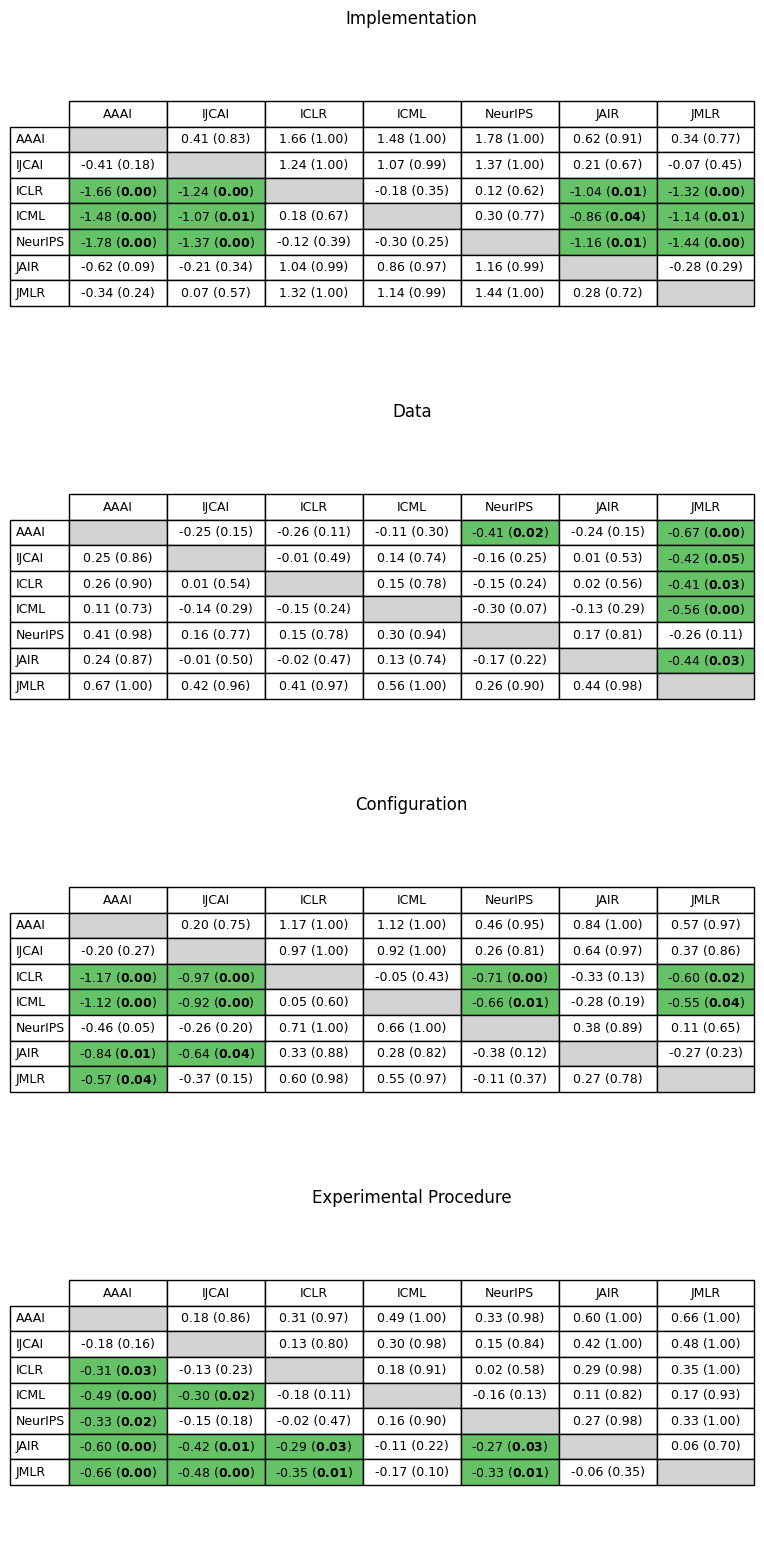

In [16]:
import matplotlib.pyplot as plt

def fmt_cell(p1, p2):
    """Return formatted string for cell: p1 (p2), bold p2 if <=0.05"""
    if p2 <= 0.05:
        return rf"{p1:.2f} ($\mathbf{{{p2:.2f}}}$)"
    return f"{p1:.2f} ({p2:.2f})"

highlight_color = "#66C266"  # medium green

fig, axes = plt.subplots(4, 1, figsize=(8, 16))  # stacked vertically

dim_idx = 0
for ax, dim in zip(axes, dimensions):
    table = tables[dim_idx]
    cell_text = []
    cell_colors = []

    for i in range(len(source_order)):
        row = []
        colors = []
        for j in range(len(source_order)):
            p1, p2 = table[i][j]
            if i == j:
                row.append("")  # diagonal
                colors.append("lightgrey")
            else:
                row.append(fmt_cell(p1, p2))
                colors.append(highlight_color if p2 <= 0.05 else "white")
        cell_text.append(row)
        cell_colors.append(colors)

    tbl = ax.table(
        cellText=cell_text,
        rowLabels=source_order,
        colLabels=source_order,
        cellColours=cell_colors,
        loc="center",
        cellLoc='center'
    )

    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1, 1.2)  # slightly larger height for readability

    ax.set_title(dim, fontsize=12, pad=6)
    ax.axis("off")
    dim_idx += 1

plt.tight_layout(pad=2)
plt.show()


In [26]:

def fmt_cell(p1, p2):
    """Return formatted string for cell: p1 (p2), bold p2 if <=0.05"""
    if p2 <= 0.05:
        return f"\\textbf{{{p2:.2f}}} ({p1:.2f})"
    return f"{p2:.2f}"

latex_lines = ["\\begin{table}[ht]", "\\centering"]

for dim, table in zip(dimensions, tables):
    latex_lines.append(f"\\textbf{{{dim}}}\\\\")
    latex_lines.append("\\begin{tabular}{l" + "l"*len(source_order) + "}")
    latex_lines.append(" & " + " & ".join(source_order) + " \\\\ \\hline")

    for i, row_label in enumerate(source_order):
        row_cells = []
        for j in range(len(source_order)):
            p1, p2 = table[i][j]
            if i == j:
                row_cells.append("-")
            else:
                row_cells.append(fmt_cell(p1, p2))
        latex_lines.append(f"{row_label} & " + " & ".join(row_cells) + " \\\\")
    latex_lines.append("\\end{tabular}\\\\[1em]")  # space between tables

# Add caption
latex_lines.append("\\caption{Permutation test of 1 000 000 resamples between sources per dimension, where each row is tested to be smaller than each column. The statistically significant results are highlighted in \\textbf{bold} with the distances in brackets.}")
# Add label
latex_lines.append("\\label{tab:permutation_test_sources_dimensions}")
latex_lines.append("\\end{table}")

# Save to file
with open("latex/tables/permutation_tables_all.tex", "w") as f:
    f.write("\n".join(latex_lines))


## Item Level insights

We would like to review certain item-level things...

In [18]:
# Check dark pattern percentage for implementation, which we define as implentation cost > 4 yet a URL is given by the authors

dark_subset = df[(df['Implementation'] > 5) & (df['implementation_link'] == True)]
print(f"Total percentage of papers that have an Implementation Dark Pattern: {(len(dark_subset) / len(df)) * 100:.4f}% ({(len(dark_subset) / len(df[df["implementation_link"] == True])) * 100:.4f}% Implementation proportion) ({len(dark_subset)} papers)\n")

for source in source_order:
    print(f"[{source}] Share of darkpattern: {len(dark_subset[dark_subset['source'] == source]) / len(dark_subset) * 100:.4f}%", f"({len(dark_subset[dark_subset['source'] == source]) / len(df) * 100:.4f}% of all papers)")
    dark_pattern_papers = len(df[(df['source'] == source) & (df['Implementation'] > 4) & (df['implementation_link'] == True)])
    print(f"\tPercentage of {source} with Implementation Dark Pattern: {(dark_pattern_papers / len(df[df['source'] == source])) * 100:.4f}%")


Total percentage of papers that have an Implementation Dark Pattern: 4.2204% (6.5934% Implementation proportion) (36 papers)

[AAAI] Share of darkpattern: 25.0000% (1.0551% of all papers)
	Percentage of AAAI with Implementation Dark Pattern: 8.6957%
[IJCAI] Share of darkpattern: 16.6667% (0.7034% of all papers)
	Percentage of IJCAI with Implementation Dark Pattern: 8.1301%
[ICLR] Share of darkpattern: 16.6667% (0.7034% of all papers)
	Percentage of ICLR with Implementation Dark Pattern: 4.7244%
[ICML] Share of darkpattern: 8.3333% (0.3517% of all papers)
	Percentage of ICML with Implementation Dark Pattern: 2.3077%
[NeurIPS] Share of darkpattern: 13.8889% (0.5862% of all papers)
	Percentage of NeurIPS with Implementation Dark Pattern: 5.7851%
[JAIR] Share of darkpattern: 13.8889% (0.5862% of all papers)
	Percentage of JAIR with Implementation Dark Pattern: 8.0000%
[JMLR] Share of darkpattern: 5.5556% (0.2345% of all papers)
	Percentage of JMLR with Implementation Dark Pattern: 1.7544%


In [ ]:
# Check dark pattern for data. As we in general assumed datasets to have 'equal proportional contribution' to the cost, we calculate as follows:

dark_subset = df[(df['Data'] > 5) & (df['public_data_fraction'] == 0.0)]
print(f"Percentage of private data papers that have bad documentation: {(len(dark_subset) / len(df[df['public_data_fraction'] == 0])) * 100:.4f}% ({len(dark_subset)} papers, {len(df[df['public_data_fraction'] == 0]) / len(df) * 100:.2f}% of all papers)\n")

for source in source_order:
    print(f"[{source}] Share of darkpattern: {len(dark_subset[dark_subset['source'] == source]) / len(dark_subset) * 100:.4f}%")
    dark_pattern_papers = len(df[(df['source'] == source) & (df['Data'] > 4) & (df['public_data_fraction'] == True)])
    print(f"\tPercentage of {source} with Data Dark Pattern: {(dark_pattern_papers / len(df[df['source'] == source])) * 100:.4f}%")

Percentage of private data papers that have bad documentation: 84.8485% (28 papers, 3.8687% of all papers)

[AAAI] Share of darkpattern: 21.4286%
	Percentage of AAAI with Data Dark Pattern: 6.5217%
[IJCAI] Share of darkpattern: 39.2857%
	Percentage of IJCAI with Data Dark Pattern: 4.8780%
[ICLR] Share of darkpattern: 7.1429%
	Percentage of ICLR with Data Dark Pattern: 7.8740%
[ICML] Share of darkpattern: 17.8571%
	Percentage of ICML with Data Dark Pattern: 5.3846%
[NeurIPS] Share of darkpattern: 7.1429%
	Percentage of NeurIPS with Data Dark Pattern: 8.2645%
[JAIR] Share of darkpattern: 7.1429%
	Percentage of JAIR with Data Dark Pattern: 10.0000%
[JMLR] Share of darkpattern: 0.0000%
	Percentage of JMLR with Data Dark Pattern: 19.2982%


In [20]:
len(df[df['public_data_fraction'] == 0]) / len(df) * 100

3.8686987104337636

In [ ]:
results = [[] for _ in dimensions]

for dimension in dimensions:
    print(f"{dimension}:")
    for venue in source_order:
        venue_df = df[df['source'] == venue]
        print(f"\t{venue} total appendix mentions: {(venue_df[f"{dimension}_appendix_mentions"] > 0).sum()}")
    print()

Implementation:
	AAAI total appendix mentions: 8
	IJCAI total appendix mentions: 5
	ICLR total appendix mentions: 18
	ICML total appendix mentions: 17
	NeurIPS total appendix mentions: 11
	JAIR total appendix mentions: 4
	JMLR total appendix mentions: 7


Data:
	AAAI total appendix mentions: 13
	IJCAI total appendix mentions: 10
	ICLR total appendix mentions: 34
	ICML total appendix mentions: 53
	NeurIPS total appendix mentions: 39
	JAIR total appendix mentions: 7
	JMLR total appendix mentions: 13


Configuration:
	AAAI total appendix mentions: 15
	IJCAI total appendix mentions: 12
	ICLR total appendix mentions: 79
	ICML total appendix mentions: 67
	NeurIPS total appendix mentions: 59
	JAIR total appendix mentions: 10
	JMLR total appendix mentions: 15


Experimental Procedure:
	AAAI total appendix mentions: 5
	IJCAI total appendix mentions: 3
	ICLR total appendix mentions: 20
	ICML total appendix mentions: 22
	NeurIPS total appendix mentions: 17
	JAIR total appendix mentions: 2
	JMLR t

## Checking papers with Awards

To check whether the papers than won an award (conferences), we check whether they are out of distribution and whether they are significantly less costly than their sources.

In [ ]:
# Compare award papers per source and check if they are in or out of distribution
import scipy
awards_table = [[] for _ in dimension_order]

conference_source_order = ["AAAI", "IJCAI", "ICLR", "ICML", "NeurIPS"]  # Not all venues were applicable for awards

for dim_index, dimension in enumerate(dimension_order):
    for source in conference_source_order:
        kstest_res = scipy.stats.kstest(df[df["source"] == source][dimension].to_numpy(),
                                        df_awards[df_awards["source"] == source][dimension].to_numpy())
        ks_result = f"{kstest_res.statistic:.2f} ({kstest_res.pvalue:.2f})"

        if kstest_res.pvalue < 0.05:  # Write significant values in boldface
            ks_result = "\\textbf{" + f"{kstest_res.statistic:.2f}" + "} " + f"({kstest_res.pvalue:.2f})"

        permutation_test_res = scipy.stats.permutation_test([df[df["source"] == source][dimension].to_numpy(),
                                                             df_awards[df_awards["source"] == source][dimension].to_numpy()],
                                                            statistic_func,
                                                            n_resamples=999999,
                                                            alternative="less")
        p_result = f"{permutation_test_res.statistic:.2f} ({permutation_test_res.pvalue:.2f})"
        if permutation_test_res.pvalue < 0.05:
            print(f"[{dimension}] Awards of {source} are significantly less costly ({permutation_test_res.statistic:.2f}, {permutation_test_res.pvalue:.2f})")
            p_result = "\\textbf{" + f"{permutation_test_res.statistic:.2f}" + "} " + f"({permutation_test_res.pvalue:.2f})"
        awards_table[dim_index].append((ks_result, p_result))



[Data] Awards of ICML are significantly less costly (-1.12, 0.00)


In [24]:
import pandas as pd

def awards_table_to_latex(
    awards_table,
    dimension_order,
    source_order,
    n_cols=2,
    caption=None,
    label=None,
):
    """
    LaTeX table with subtables:
    - One subtable per dimension
    - First col left-aligned, other two right-aligned
    - Dimension name above the table (bold, top-left)
    - Columns: KS Test / Permutation Test
    """
    subtables = []
    for d_idx, dim in enumerate(dimension_order):
        # Build DataFrame
        df = pd.DataFrame(
            awards_table[d_idx],
            index=source_order,
            columns=["KS Test", "Permutation Test"]
        )

        # Export to LaTeX, keep column names
        latex_tabular = df.to_latex(
            index=True,
            index_names=False,
            escape=False,
            column_format="lrr"  # left index, right data
        )

        # Insert bold dimension header above the table
        lines = latex_tabular.splitlines()

        # Find the line with \toprule
        for i, line in enumerate(lines):
            if line.strip().startswith("\\toprule"):
                # Insert dimension name right after \toprule
                lines.insert(i + 1, f"\\textbf{{{dim}}}\\\\[0.3em]")
                break

        latex_table = "\n".join(lines)

        subtables.append(
            f"\\begin{{minipage}}{{0.45\\linewidth}}\n\\centering\n{latex_table}\n\\end{{minipage}}"
        )

    # Arrange subtables n_cols per row
    rows = []
    for i in range(0, len(subtables), n_cols):
        rows.append("\n\\hfill\n".join(subtables[i:i+n_cols]))

    # Wrap in main table
    parts = ["\\begin{table}[ht]", "\\centering", "\n\n".join(rows)]
    if caption:
        parts.append(f"\\caption{{{caption}}}")
    if label:
        parts.append(f"\\label{{{label}}}")
    parts.append("\\end{table}")

    return "\n".join(parts)

latex = awards_table_to_latex(
    awards_table,
    dimension_order,
    conference_source_order,
    caption="Kolmogorov–Smirnov test and Permutation test per source and dimension between papers with and without awards."
            "The P-values are in brackets. The statistically significant results are highlighted in \\textbf{bold}.",
    label="tab:test_sources_dimensions_awards"
)

print(latex)

\begin{table}[ht]
\centering
\begin{minipage}{0.45\linewidth}
\centering
\begin{tabular}{lrr}
\toprule
\textbf{Implementation}\\[0.3em]
 & KS Test & Permutation Test \\
\midrule
AAAI & 0.20 (0.99) & 0.43 (0.63) \\
IJCAI & 0.34 (0.33) & 2.27 (0.95) \\
ICLR & 0.14 (0.94) & -0.05 (0.48) \\
ICML & 0.18 (0.51) & -1.09 (0.11) \\
NeurIPS & 0.15 (0.81) & -0.41 (0.31) \\
\bottomrule
\end{tabular}
\end{minipage}
\hfill
\begin{minipage}{0.45\linewidth}
\centering
\begin{tabular}{lrr}
\toprule
\textbf{Data}\\[0.3em]
 & KS Test & Permutation Test \\
\midrule
AAAI & 0.14 (1.00) & 0.07 (0.55) \\
IJCAI & 0.14 (0.99) & 0.39 (0.70) \\
ICLR & 0.14 (0.93) & -0.24 (0.32) \\
ICML & \textbf{0.33} (0.03) & \textbf{-1.12} (0.00) \\
NeurIPS & 0.22 (0.34) & -0.65 (0.06) \\
\bottomrule
\end{tabular}
\end{minipage}

\begin{minipage}{0.45\linewidth}
\centering
\begin{tabular}{lrr}
\toprule
\textbf{Configuration}\\[0.3em]
 & KS Test & Permutation Test \\
\midrule
AAAI & 0.28 (0.86) & -0.78 (0.28) \\
IJCAI & \textbf{